<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Payday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from my_library import *

14:18:21 Starting...
14:18:21 Installing yfinance into Google notebook...
14:18:24 Installing arch into Google notebook...
14:18:33 Initialized.


## Get the Data

In [ ]:
data,ticker_name=download(ticker:='SPY',end='2019-12-31',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=list(map(lambda x:x.strftime("%A"),data.index))
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=list(map(lambda x:x.strftime("%B"),data.index))
data['FirstPayment']=(data['Monthday']==1)|(data['Monthday'].shift(-1).isin([2,3,4]))&(data['Month']!=data['Month'].shift(-1))
data['SecondPayment']=(data['Monthday']>=15)&(data['Monthday'].shift()<15)
data['Payday']=(data['FirstPayment']|data['SecondPayment']).apply(lambda x:"Payday" if x else "Regular")
data['Julian']=list(map(lambda x:float((x-data.index[0]).n),data.index))
data['DaysSincePayment']=data['Julian']-(data['Julian']*data['Payday'].apply(lambda x:one if x=="Payday" else np.nan)).ffill()
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month,FirstPayment,SecondPayment,Payday,Julian,DaysSincePayment
1993-02-01,24.626446,24.626446,24.469922,24.469922,480500,0.711302,Monday,1,28,February,True,False,Payday,0.0,0.0
1993-02-02,24.678602,24.695994,24.556861,24.609036,201300,0.211790,Tuesday,2,28,February,False,False,Regular,1.0,1.0
1993-02-03,24.939487,24.956879,24.696006,24.713397,529400,1.057131,Wednesday,3,28,February,False,False,Regular,2.0,2.0
1993-02-04,25.043814,25.095988,24.748158,25.026422,531500,0.418318,Thursday,4,28,February,False,False,Regular,3.0,3.0
1993-02-05,25.026449,25.078624,24.887317,25.026449,492100,-0.069336,Friday,5,28,February,False,False,Regular,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917725,297.315186,296.769826,297.259727,52990000,0.152791,Monday,23,31,December,False,False,Regular,9821.0,7.0
2019-12-24,296.926941,297.194980,296.621892,297.148774,20270000,0.003104,Tuesday,24,31,December,False,False,Regular,9822.0,8.0
2019-12-26,298.507599,298.516851,297.305963,297.315187,30911200,0.532339,Thursday,26,31,December,False,False,Regular,9824.0,10.0
2019-12-27,298.433594,299.302479,297.897487,299.247021,42528800,-0.024792,Friday,27,31,December,False,False,Regular,9825.0,11.0


14:18:38 Wrote plot to Daily Returns of S&P 500 Index ETF.png.


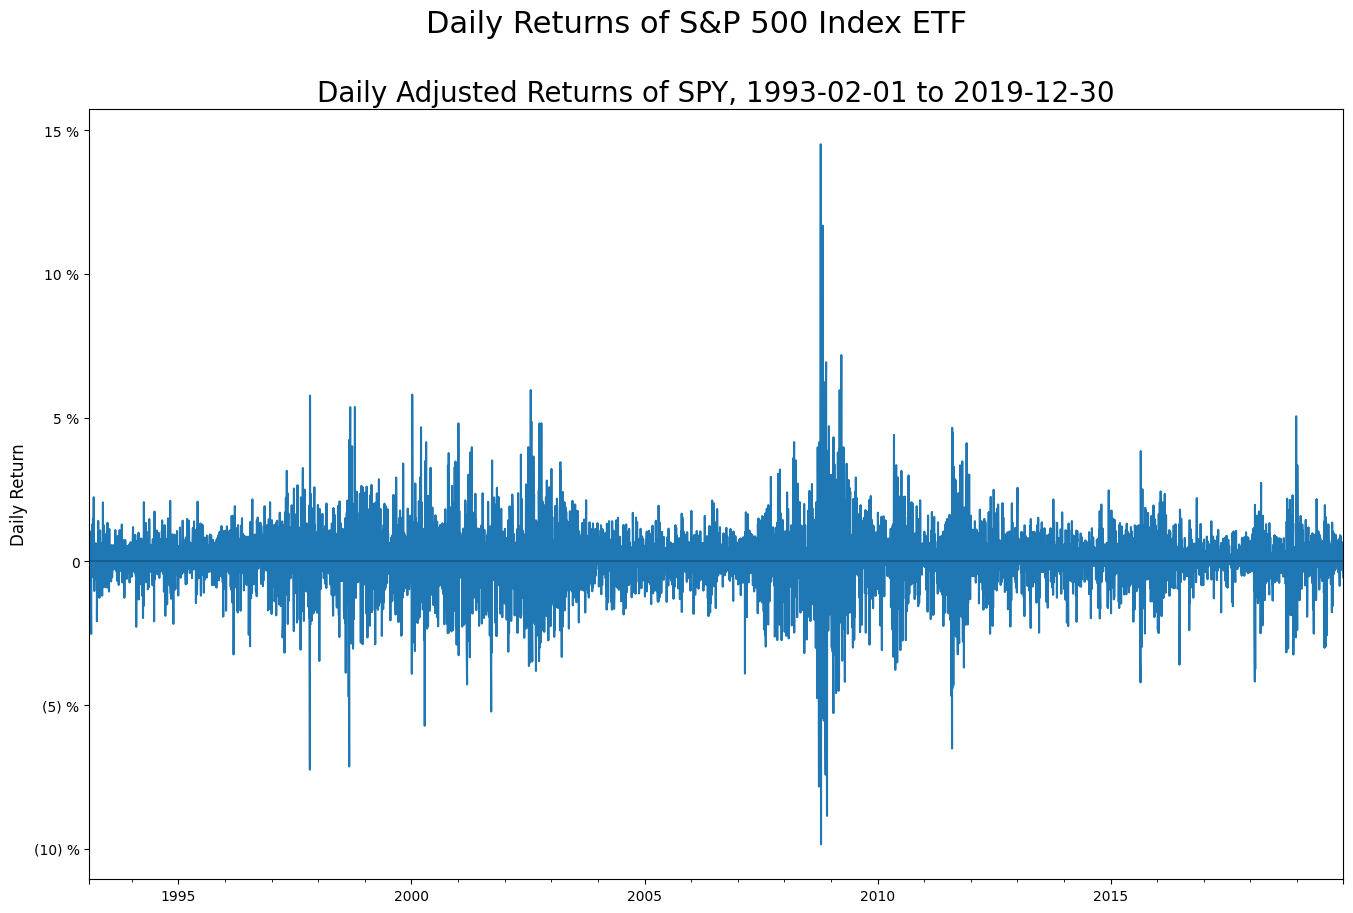

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
data['Return'].plot(ax=plot)
plot.set_ylabel("Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Daily Returns of {}".format(ticker_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
plot.axhline(color='black',alpha=0.2)
nprint("Wrote plot to {}.".format(filename))

## Analyse Returns by Selected Period
### First Just a Simple Grouped Mean

14:18:39 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value,Significance
Day of Week,,,,,,,
Monday,0.040139,1.264921,1277,0.035397,1.133961,0.257024,
Tuesday,0.071447,1.159080,1389,0.031100,2.297310,0.021749,*
Wednesday,0.051835,1.095635,1390,0.029387,1.763863,0.077975,
Thursday,0.023568,1.126048,1364,0.030489,0.772991,0.439662,
Friday,0.028855,1.064548,1358,0.028888,0.998853,0.318044,


14:18:40 Wrote plot to Average Returns of S&P 500 Index ETF by Day of Week.png.


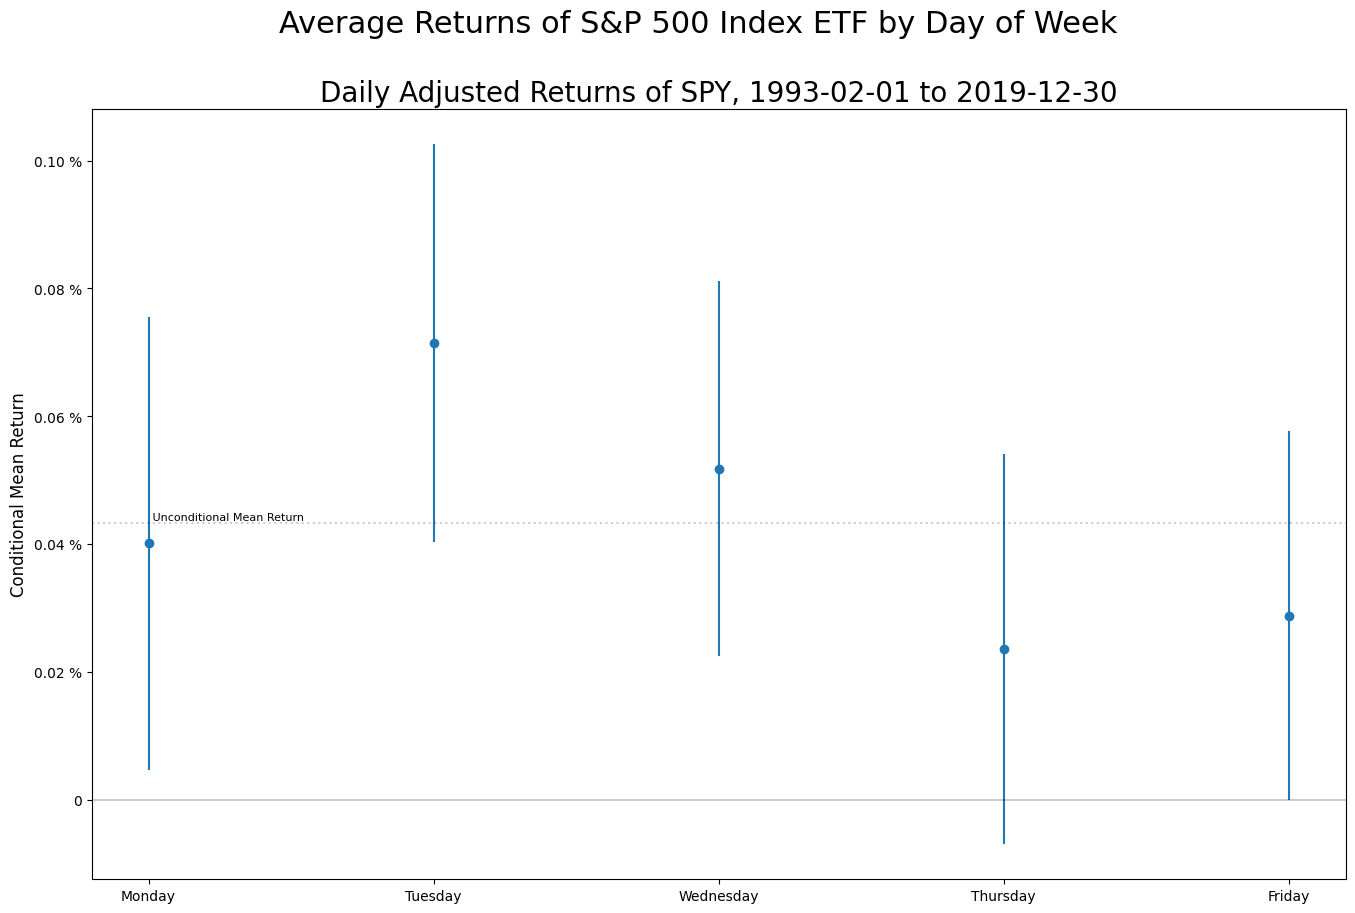

In [ ]:
from scipy.stats import t as studentt

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return',group_name:='Weekday']].groupby(group_name)).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
results.index.name=(group_long_name:='Day of Week' if group_name=='Weekday' else 'Day of Month' if group_name=='Monthday' else group_name)

if group_name=='Weekday':
    results=results.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday'])

display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Conditional Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel(group_long_name if group_name=='Monthday' else None,fontsize=12)
plot.axhline(m:=data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
plot.text(x[0],m,' Unconditional Mean Return',fontsize=8,ha='left',va='bottom')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### One Way ANOVA Analysis

In [ ]:
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("One Way ANOVA Analysis by {}".format(group_name))
anova=anova_lm(OLSformula("Return ~ {}".format(group_name),data).fit(),typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

14:18:42 One Way ANOVA Analysis by Weekday


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,2.028850,4.0,0.388621,0.816939,
Within Groups,8839.842268,6773.0,,,


### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [ ]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data[group_name],columns=[group_name],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

14:18:42 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711302
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211790
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057131
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418318
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069336
...,...,...,...,...,...,...
2019-12-23,1.0,0.0,0.0,0.0,0.0,0.152791
2019-12-24,0.0,1.0,0.0,0.0,0.0,0.003104
2019-12-26,0.0,0.0,0.0,1.0,0.0,0.532339
2019-12-27,0.0,0.0,0.0,0.0,1.0,-0.024792


14:18:42                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3886
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.817
Time:                        14:18:42   Log-Likelihood:                -10518.
No. Observations:                6778   AIC:                         2.105e+04
Df Residuals:                    6773   BIC:                         2.108e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0401      0.032      1.256

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

In [ ]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False,lags=0)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan,zero,zero,zero]+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
display(results.replace(np.nan,""))

14:18:43 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8763.597811609661
            Iterations: 18
            Function evaluations: 231
            Gradient evaluations: 18
14:18:45                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8763.60
Distribution:      Generalized Error Distribution   AIC:                           17547.2
Method:                        Maximum Likelihood   BIC:                           17615.4
                                                    No. Observations:                 6778
Date:                            Tue, Apr 29 2025   Df Residuals:                  

,Estimate,Std.Err.,Null Value,t Score,p Value,Significance
Monday,0.053277,0.019021,0.0,2.800982,0.005095,**
Tuesday,0.035980,0.021194,0.0,1.69767,0.08957,
Wednesday,0.075192,0.018111,0.0,4.151661,0.000033,***
Thursday,0.042090,0.019512,0.0,2.157096,0.030998,*
Friday,0.071237,0.020476,0.0,3.479128,0.000503,***
omega,0.017797,0.003186,,,,
alpha[1],-0.001303,0.006676,0.0,-0.195127,0.845294,
gamma[1],0.196251,0.023181,0.0,8.466094,0.0,***
beta[1],0.886567,0.012111,0.0,73.200981,0.0,***
nu,1.354813,0.037184,2.0,-17.351099,0.0,***


### Repeat the Simple Plot by Selected Period

14:18:46 Wrote plot to Estimated Daily Returns of S&P 500 Index ETF by Day of Week.png.


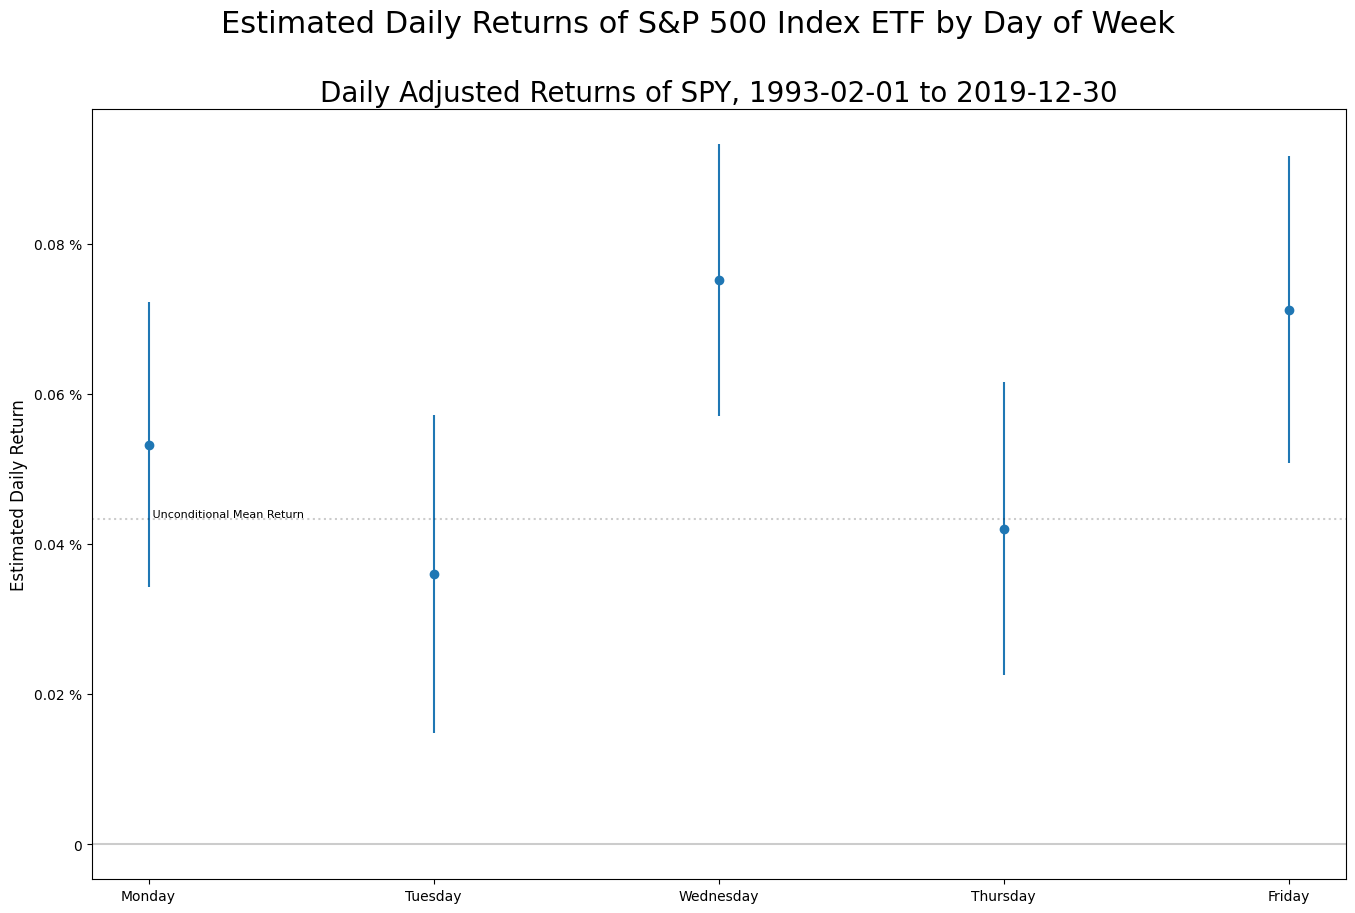

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index[:-5],results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Estimated Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(m:=data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
plot.text(x[0],m,' Unconditional Mean Return',fontsize=8,ha='left',va='bottom')
figure.suptitle(title:="Estimated Daily Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Compute the MLRT and AIC changes

In [ ]:
from scipy.stats import chi2

aic=pd.DataFrame({
    'Model':['OLS','GJR-GARCH(1,1,1)'],
    'AIC':[ols_fit.aic,gjr_fit.aic],
    '-logL':[ols_fit.llf,gjr_fit.loglikelihood],
    'params':[ols_fit.params.shape[0]+1,gjr_fit.params.shape[0]]
}).set_index('Model')
aic.loc['Change']=aic.diff().iloc[-1]
aic.loc['Change','Chi.Sq.']=aic.loc['Change','-logL']*two
aic.loc['Change','p Value']=chi2.sf(aic.loc['Change','Chi.Sq.'],aic.loc['Change','params'])
display(aic.replace(np.nan,""))

,AIC,-logL,params,Chi.Sq.,p Value
Model,,,,,
OLS,21045.279173,-10517.639587,6.0,,
"GJR-GARCH(1,1,1)",17547.195623,-8763.597812,10.0,,
Change,-3498.083550,1754.041775,4.0,3508.08355,0.0
